Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

Your code starts here:

In [1]:
#this is some free form exploration.  Just trying to figure out whats going on here and poke 
#around some before I get to my actual strategy.

import pandas as pd

#the dots represent how many folders up we have to go before looking for the file
folder = '../../DS-Unit-2-Build/bosch-production-line-performance/'

#we are going to read in chunks of 1k for right now to keep from overloading my ram
cat_iter = pd.read_csv(folder + 'train_categorical.csv', iterator = True, chunksize = 1000)

num_iter = pd.read_csv(folder + 'train_numeric.csv', iterator = True, chunksize = 1000)

date_iter = pd.read_csv(folder + 'train_date.csv', iterator = True, chunksize = 1000)

In [2]:
#This warning has to do with how pandas reads categorical data.  Basically pandas wants me
#to read the whole file and infer the data type from there.  Or I can pass in the datatype.
#But since I haven't fully explored yet we'll just note this warning for what its and move
#on
cat = cat_iter.get_chunk()

/home/felix/anaconda3/envs/anaconda_env/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: DtypeWarning: Columns (96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,335,407,410,413,416,419,422,425,428,431,434,437,440,443,446,449,452,455,458,461,464,467,470,473,476,479,482,485,488,491,494,497,500,503,506,509,512,515,518,611,614,617,620,623,626,629,632,635,638,641,644,647,650,653,656,659,662,665,668,671,674,677,680,683,686,689,692,695,698,701,704,707,710,713,716,719,722,1005,1007,1008,1010,1011,1013,1014,1016,1017,1019,1020,1022,1023,1025,1026,1028,1029,1031,1032,1034,1035,1037,1038,1040,1041,1043,1044,1046,1047,1049,1050,1052,1126,1129,1132,1135,1138,1141,1144,1147,1183,1185,1188,1191,1194,1197,1200,

In [3]:
#eh not super useful
cat.describe()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
count,1000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,998.613000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,586.907348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,491.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,973.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1511.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2055.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Okay baseline what our chunk size is
cat.shape

(1000, 2141)

In [5]:
#okay checking to see if there are any values in this chunk.  There definitely are
cat.drop(columns = 'Id').notna().sum().value_counts()

0      1524
1       156
693      60
5        45
3        40
161      27
86       27
15       25
9        21
12       21
6        20
49       19
45       19
13       19
8        18
14       17
21       16
2        16
25       13
94       12
39       11
4         8
669       3
34        1
35        1
93        1
dtype: int64

In [6]:
#Lets try a drop na on only rows that are all nans. and see what we end up losing.
cat.drop(columns = 'Id').dropna(how = 'all').shape

(802, 2140)

In [7]:
#Okay so there are definitely values in there, I just have visibility problem.  I'm always
#going to have a hard time inspecting them because the dataset is so wide.
#I wonder if PCA may come in hand?  I should explore that as one of my models, see if I can
#get some Insight from it.

## Explore and Clean strategy
Okay after taking that quick look above, I know that just chunking in information isn't going to be as useful as I want it to be.  Essentially I'm chunking in huge, mostly empty dataframes.  So I think I will run my numerical and categorical data through two different models, and use a stacking/voting techinque.  So basically if a uniqe part had no categorical data, then my categorical model will not have a vote so to speak.
### Step 1 verify id
I need to verify that in each data set, that a unique part ID is never duplicated.  I'd assume not, but I can read in that column and find out.
### Step 2 Inspect
Check the resulting data frame, and get an idea of what is actually in there.
### Step 3 Throw out nans
Get rid of rows with all nans.  For right now I don't care about those
### Step 4 Impute
I can't just leave those nans in there.  So I'm going to try some imputing.
### Step 5 basic model
I just want to get a simple mvp model to try.

### Step 1

In [8]:
#step 1
check_id = pd.read_csv(folder + 'train_numeric.csv', usecols = ['Id'], squeeze = True)
print(check_id.shape)

(1183747,)


In [9]:
check_id.duplicated().sum()

0

In [10]:
#okay definitely unique.  Lets verify we have the same IDs in the categorical and the date
#data sets
cat_id = pd.read_csv(folder + 'train_categorical.csv', usecols = ['Id'], squeeze = True)
print(cat_id.shape)

(1183747,)


In [11]:
#same shape, that is a good sign
cat_id.duplicated().sum()

0

In [12]:
#if we have exactly 1:1 IDs in the data sets then this should equal the size of our id shape
pd.concat([check_id, cat_id]).duplicated().sum()

1183747

### Step 2

In [13]:
#okay lets just knock out a quick mvp, and then we can think about how to make this reproducable
#for the full datasets.  I'm going to work with train_numeric right now, because it has our
#target in it, so I don't have to load in a bunch of data sets.

num_iter = pd.read_csv(folder + 'train_numeric.csv', iterator = True, chunksize = 1000)

num = num_iter.get_chunk()
print(num.shape)
num.describe()

(1000, 970)


,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
count,1000.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,24.000000,24.0,24.0,24.0,24.000000,39.000000,39.0,39.000000,39.0,1000.000000
mean,998.613000,-0.001823,-0.002838,0.009395,0.009162,-0.000037,0.003355,0.000878,0.006267,0.000722,...,-0.000042,0.0,0.0,0.0,0.020833,-0.000026,0.0,0.000462,0.0,0.004000
std,586.907348,0.079192,0.093521,0.214535,0.214192,0.094356,0.163048,0.019698,0.105601,0.119745,...,0.000204,0.0,0.0,0.0,0.254489,0.000160,0.0,0.002882,0.0,0.063151
min,4.000000,-0.251000,-0.258000,-0.397000,-0.397000,-0.317000,-0.566000,-0.044000,-0.232000,-0.327000,...,-0.001000,0.0,0.0,0.0,-0.250000,-0.001000,0.0,0.000000,0.0,0.000000
25%,491.750000,-0.049000,-0.056000,-0.179000,-0.179000,-0.056000,-0.066000,-0.015000,-0.072000,-0.082000,...,0.000000,0.0,0.0,0.0,-0.250000,0.000000,0.0,0.000000,0.0,0.000000
50%,973.500000,0.003000,0.004000,-0.024000,-0.034000,0.031000,0.070000,0.000000,0.008000,0.000000,...,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.000000
75%,1511.500000,0.056000,0.063000,0.294000,0.294000,0.074000,0.116000,0.015000,0.088000,0.081000,...,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.000000,0.0,0.000000
max,2055.000000,0.252000,0.250000,0.530000,0.548000,0.248000,0.206000,0.052000,0.328000,0.347000,...,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.018000,0.0,1.000000


In [14]:
#okay good this is looking like it has little more info available.
num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Step 3

In [15]:
num.drop(columns = ['Id', 'Response']).dropna(how = 'all').shape

(999, 968)

In [16]:
#eeeeeeehhhhhh that is literally only one line of the data I chunked in.  Okay, lesson learned
#Though the categorical data set might be missing quite a few rows, this numerical dataset seems
#to be pretty intact. Ultimately, I'm going to skip this step and knock out a baseline

### step 3.5
Create a baseline with a dummy.

In [17]:
target = 'Response'
X = num.drop(columns = ['Id', target])
y = num['Response']

In [18]:
print(X.shape, y.shape)
X.head()

(1000, 968) (1000,)


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
y.value_counts()

0    996
1      4
Name: Response, dtype: int64

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

#since we decided to go with a guessing basline, uniform gives us a random guess
baseline = DummyClassifier(strategy = 'uniform')

baseline.fit(X, y)

y_pred = baseline.predict(X)

#we are using precision as our metric, but I'm curious about accuracy as well
print('The precision of a random guess baseline is: ', precision_score(y, y_pred))
print('The accuracy of a random guess baseline is: ', accuracy_score(y, y_pred))

The precision of a random guess baseline is:  0.0038535645472061657
The accuracy of a random guess baseline is:  0.481


In [21]:
#Holy smokes a random guess has a crazy low precision.  Good to know the bar is so low.
#lets go ahead and pull in another chunk for testing.  Might be a bit aggresive for
#a test set right now, but it is pretty easy.
X_test = num_iter.get_chunk()
y_test = X_test[target]
X_test = X_test.drop(columns = ['Id', target])
X_test.head()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,-0.134,-0.175,0.294,0.294,-0.013,-0.021,0.045,0.288,0.076,-0.056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,-0.062,-0.056,-0.033,-0.052,-0.056,0.116,0.008,0.048,0.056,-0.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.05,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0
1004,0.003,0.004,-0.197,-0.179,-0.100,-0.021,-0.015,-0.072,0.112,0.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 4 + Step 5

In [22]:
#lets do a quick one with cross validation, no hyperparameter tweaking, regression classifier
#with so much missing data, median might be a better choice than mean for imputing
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    SimpleImputer(strategy = 'median'),
    LogisticRegression(random_state = 42)
)

In [23]:
#lets do a quick cross validation and see how this goes
results = cross_validate(
    pipeline,
    X,
    y,
    scoring = ['precision', 'accuracy'],
    cv = 4,
    n_jobs = -1,
    verbose = 10
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


In [24]:
#I must have some leakage going on.  That accuracy is way too high, and likely the reason I have
#0 precision.
results

{'fit_time': array([0.0485456 , 0.0512464 , 0.05025935, 0.04969835]),
 'score_time': array([0.0055666 , 0.00540042, 0.00507832, 0.00529742]),
 'test_precision': array([0., 0., 0., 0.]),
 'test_accuracy': array([0.996, 0.996, 0.996, 0.996])}

In [25]:
#verify the shape of my X before feeding it to my pipeline
X.shape

(1000, 968)

In [26]:
#I want to follow this through though and see how this all tests out so

pipeline.fit(X, y)

y_pred = pipeline.predict(X_test)

print('My models precision is: ', precision_score(y_test, y_pred))
print('My models accuracy is: ', accuracy_score(y_test, y_pred))

My models precision is:  0.0
My models accuracy is:  0.997


/home/felix/anaconda3/envs/anaconda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Leakage
If I were over fitting, I'd expect my test set to evaluate low.  But I'm getting crazy high accuracy on my test set.  So I must be leaking somewhere.  This will be a bugger to track down.

In [27]:
#first lets take a look at those column names.  Maybe I missed something.
print(X.columns)

Index(['L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8', 'L0_S0_F10',
       'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16', 'L0_S0_F18',
       ...
       'L3_S50_F4243', 'L3_S50_F4245', 'L3_S50_F4247', 'L3_S50_F4249',
       'L3_S50_F4251', 'L3_S50_F4253', 'L3_S51_F4256', 'L3_S51_F4258',
       'L3_S51_F4260', 'L3_S51_F4262'],
      dtype='object', length=968)


In [28]:
for col in X.columns:
    print(col, end = ' ')

L0_S0_F0 L0_S0_F2 L0_S0_F4 L0_S0_F6 L0_S0_F8 L0_S0_F10 L0_S0_F12 L0_S0_F14 L0_S0_F16 L0_S0_F18 L0_S0_F20 L0_S0_F22 L0_S1_F24 L0_S1_F28 L0_S2_F32 L0_S2_F36 L0_S2_F40 L0_S2_F44 L0_S2_F48 L0_S2_F52 L0_S2_F56 L0_S2_F60 L0_S2_F64 L0_S3_F68 L0_S3_F72 L0_S3_F76 L0_S3_F80 L0_S3_F84 L0_S3_F88 L0_S3_F92 L0_S3_F96 L0_S3_F100 L0_S4_F104 L0_S4_F109 L0_S5_F114 L0_S5_F116 L0_S6_F118 L0_S6_F122 L0_S6_F132 L0_S7_F136 L0_S7_F138 L0_S7_F142 L0_S8_F144 L0_S8_F146 L0_S8_F149 L0_S9_F155 L0_S9_F160 L0_S9_F165 L0_S9_F170 L0_S9_F175 L0_S9_F180 L0_S9_F185 L0_S9_F190 L0_S9_F195 L0_S9_F200 L0_S9_F205 L0_S9_F210 L0_S10_F219 L0_S10_F224 L0_S10_F229 L0_S10_F234 L0_S10_F239 L0_S10_F244 L0_S10_F249 L0_S10_F254 L0_S10_F259 L0_S10_F264 L0_S10_F269 L0_S10_F274 L0_S11_F282 L0_S11_F286 L0_S11_F290 L0_S11_F294 L0_S11_F298 L0_S11_F302 L0_S11_F306 L0_S11_F310 L0_S11_F314 L0_S11_F318 L0_S11_F322 L0_S11_F326 L0_S12_F330 L0_S12_F332 L0_S12_F334 L0_S12_F336 L0_S12_F338 L0_S12_F340 L0_S12_F342 L0_S12_F344 L0_S12_F346 L0_S12_F348 L

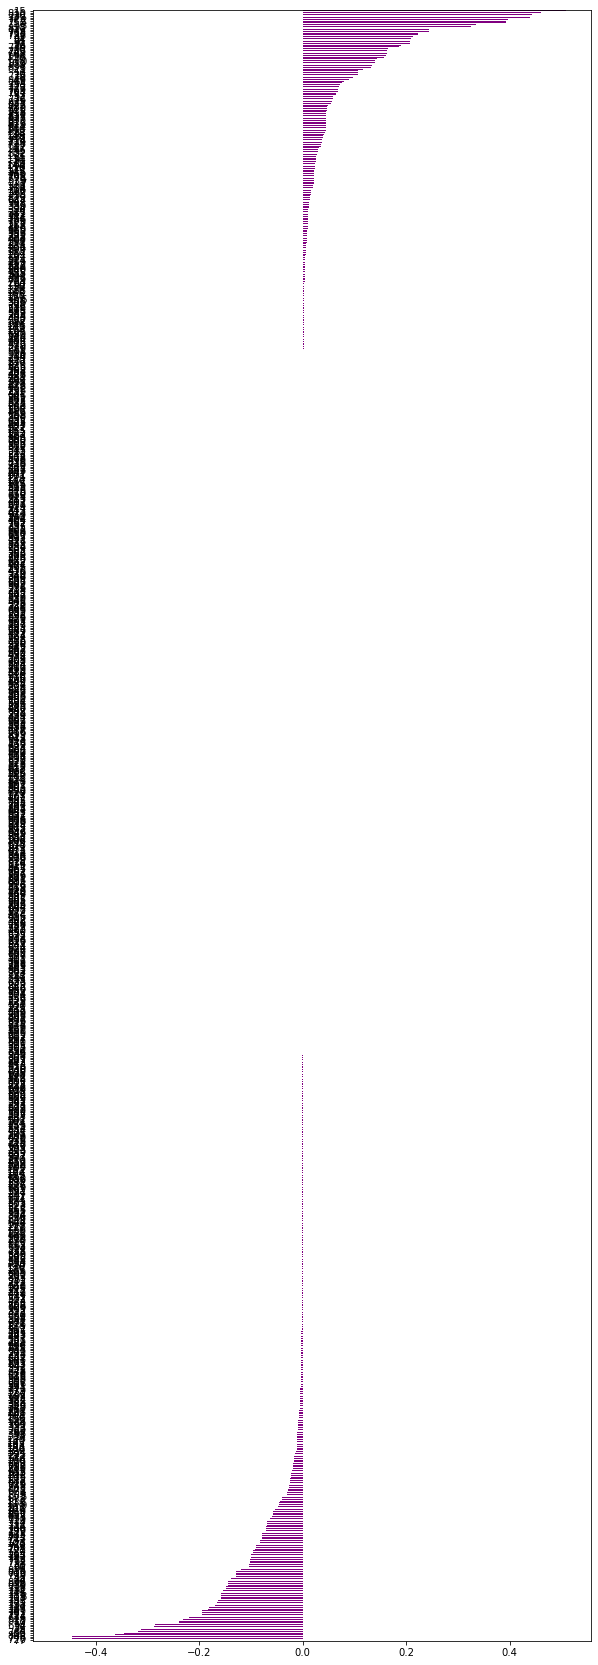

In [29]:
#Thats actually what I was expcecting.  Nothing that stands out.  Maybe feature importance
#can give me an idea of where I'm leaking at.
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
columns = X.columns

#logistic regression doesn't have a feature_importances_, but we can get the coeficients anyways
#and plot them here. Coefficients come back as a one dimensional numpy matrix, so I need to 
#set it to the first element of that matrix.
coefficients = pd.Series(model.coef_[0])
plt.figure(figsize = (10, 30))
coefficients.sort_values().plot.barh(color = 'purple');

In [30]:
len(model.coef_[0])

952

In [31]:
len(columns)

968

### To leak or not to leak
I originally thought that I was leaking data because of how high my accuracy was, while 
how low my precision was.  So I plotted my coefficients to see if there was any one or
a few columns with glaringly high importance.  Iterestingly, there really isn't.

### Re-evaluating
So I have to consider, why would I have such a high accuracy with garbage precision?  Well after meditating some, I realized it has to do with my class imbalance.  On the previous assignment I found my class to be significantly imbalanced.  Only .58%, a fraction of a percentage, of my data is in the class "Failed QC" and is ultimately what I want to predict. If I take that into account, then a chunk of 1000 rows just simply doesn't have enough data to train on. A chunk that size is only going to have 5 or 6 values that "Failed QC". So my model is training to effectively say almost everything "Passed QC" is going to be accurate, because most of my data says that.  So really what I need to do is get a better sampling of my data.  Either bigger, randomized, or stratified.  See my next assignment for my continuing strategy.